##Question4
Investigate the possibility of predicting WHO-based Covid-19 Severity using the species-level gut microbiome profile and specific metadata: Age,BMI, Gender and the total number of comorbidities. Compare the relative classification accuracy obtained using the three machine-learning basedclassifiers: Random Forest, Support Vector Machines and k-Nearest Neighbors. Identify the top 50 predictive features for this scheme. First investigate the classification performance on the three differentgroups. Then investigate the classification performance only between mild and critical_severe groups.

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [32]:
import os
import numpy as np
import pandas as pd

import sklearn
import joblib
import pickle
## Package to split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut 

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [33]:
# set working directory
os.chdir('/content/drive/MyDrive/HMDS')

# Data Loading and Processing

In [34]:
data = pd.read_csv('Assignment_RawCount_Species.csv')
data.rename(columns={'Sample': 'PID'},inplace=True)
data

,PID,Bifidobacterium_dentium,Actinobacillus_capsulatus,Clostridium_tepidiprofundi,Butyricimonas_synergistica,Erwinia_mallotivora,Slackia_heliotrinireducens,Parvibacter_caecicola,Pantoea_rwandensis,Brenneria_alni,...,Peptococcus_niger,Facklamia_ignava,Prevotella_bivia,Clostridium_cellulolyticum,Macellibacteroides_fermentans,Desulfovibrio_desulfuricans,Streptococcus_danieliae,Bacteroides_barnesiae,Catonella_morbi,Listeria_fleischmannii
0,AIIDV0435,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AIIDB0330,11,0,0,8,0,1,0,0,0,...,0,0,0,5,0,0,0,0,0,0
2,AIIDM0042,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AIIDM0318,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AIIDV1036,7,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,AIIDV0350,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108,AIIDV1085,0,0,0,0,0,6,0,0,0,...,118,0,0,0,0,0,0,0,0,0
109,AIIDM0020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110,COVIRL-201-035,10,0,0,0,0,0,2,0,0,...,0,0,0,0,0,1,0,0,1,0


In [35]:
metadata = pd.read_csv('Assignment1_Metadata.csv')
metadata.rename(columns={'Sample': 'PID'},inplace=True)
metadata

,PID,Sex,Age,BMI,HTN,Diabetes,Respiratory_disease,Heart_disease,Renal_Disease,Liver_Disease,Obesity,Malignancy,Immunosuppressive_Disease,Neurological_disease,Metabolic_Disease,Cardiovascular_Disease,comorbidities_total,WHO_severity
0,AIIDB0330,M,63,48.995023,n,y,n,y,y,n,y,n,n,n,y,y,6,critical_severe
1,AIIDM0042,M,63,30.322325,y,n,n,n,n,n,n,n,n,n,y,y,3,moderate
2,AIIDM0318,M,41,30.322325,n,n,n,n,n,n,n,n,n,n,n,n,0,critical_severe
3,AIIDV1015,F,42,57.795561,n,n,n,n,n,n,y,n,n,n,y,n,2,mild
4,AIIDV1406,F,85,23.728191,y,y,y,y,y,n,n,y,n,n,y,y,8,mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,AIIDM0040,F,43,30.322325,n,n,n,n,n,n,n,n,n,n,n,n,0,moderate
78,COVIRL-201-015,F,87,25.562130,n,n,y,y,n,n,n,n,n,n,n,y,3,critical_severe
79,AIIDV1085,M,78,26.543210,n,y,n,y,n,n,n,y,n,n,y,y,5,critical_severe
80,AIIDM0020,M,74,30.322325,y,n,n,y,n,n,n,n,n,n,y,y,4,mild


In [36]:
metadata.columns

Index(['PID', 'Sex', 'Age', 'BMI', 'HTN', 'Diabetes', 'Respiratory_disease',
       'Heart_disease', 'Renal_Disease', 'Liver_Disease', 'Obesity',
       'Malignancy', 'Immunosuppressive_Disease', 'Neurological_disease',
       'Metabolic_Disease', 'Cardiovascular_Disease', 'comorbidities_total',
       'WHO_severity'],
      dtype='object')

In [37]:
## Retaining the necessary columns for predictions
metadata.drop(['HTN', 'Diabetes', 'Respiratory_disease',
       'Heart_disease', 'Renal_Disease', 'Liver_Disease', 'Obesity',
       'Malignancy', 'Immunosuppressive_Disease', 'Neurological_disease',
       'Metabolic_Disease', 'Cardiovascular_Disease'],axis=1,inplace=True)
metadata

,PID,Sex,Age,BMI,comorbidities_total,WHO_severity
0,AIIDB0330,M,63,48.995023,6,critical_severe
1,AIIDM0042,M,63,30.322325,3,moderate
2,AIIDM0318,M,41,30.322325,0,critical_severe
3,AIIDV1015,F,42,57.795561,2,mild
4,AIIDV1406,F,85,23.728191,8,mild
...,...,...,...,...,...,...
77,AIIDM0040,F,43,30.322325,0,moderate
78,COVIRL-201-015,F,87,25.562130,3,critical_severe
79,AIIDV1085,M,78,26.543210,5,critical_severe
80,AIIDM0020,M,74,30.322325,4,mild


In [38]:
# Annotating Gender as Integer 
metadata.replace('M',1,inplace=True)
metadata.replace('F',2,inplace=True)
metadata

,PID,Sex,Age,BMI,comorbidities_total,WHO_severity
0,AIIDB0330,1,63,48.995023,6,critical_severe
1,AIIDM0042,1,63,30.322325,3,moderate
2,AIIDM0318,1,41,30.322325,0,critical_severe
3,AIIDV1015,2,42,57.795561,2,mild
4,AIIDV1406,2,85,23.728191,8,mild
...,...,...,...,...,...,...
77,AIIDM0040,2,43,30.322325,0,moderate
78,COVIRL-201-015,2,87,25.562130,3,critical_severe
79,AIIDV1085,1,78,26.543210,5,critical_severe
80,AIIDM0020,1,74,30.322325,4,mild


In [39]:
# Merging species-level gut microbiome profile and specific metadata to get Final Data
dataf = pd.merge(data,metadata,on='PID')
dataf

,PID,Bifidobacterium_dentium,Actinobacillus_capsulatus,Clostridium_tepidiprofundi,Butyricimonas_synergistica,Erwinia_mallotivora,Slackia_heliotrinireducens,Parvibacter_caecicola,Pantoea_rwandensis,Brenneria_alni,...,Desulfovibrio_desulfuricans,Streptococcus_danieliae,Bacteroides_barnesiae,Catonella_morbi,Listeria_fleischmannii,Sex,Age,BMI,comorbidities_total,WHO_severity
0,AIIDB0330,11,0,0,8,0,1,0,0,0,...,0,0,0,0,0,1,63,48.995023,6,critical_severe
1,AIIDM0042,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,63,30.322325,3,moderate
2,AIIDM0318,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,41,30.322325,0,critical_severe
3,AIIDV1015,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,42,57.795561,2,mild
4,AIIDV1406,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,2,85,23.728191,8,mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,AIIDM0040,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,43,30.322325,0,moderate
78,COVIRL-201-015,2379,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,87,25.562130,3,critical_severe
79,AIIDV1085,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,1,78,26.543210,5,critical_severe
80,AIIDM0020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,74,30.322325,4,mild


In [40]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 0 to 81
Columns: 886 entries, PID to WHO_severity
dtypes: float64(1), int64(883), object(2)
memory usage: 568.2+ KB


# MultiClass Classification

In [41]:
dataf['WHO_severity'].value_counts()

critical_severe    32
mild               31
moderate           19
Name: WHO_severity, dtype: int64

In [42]:
#check for duplicates
duplicate = dataf.duplicated()
print(duplicate.sum())

0


### Train-Test Split

In [43]:
### splitting of data in 75-25
X_train, X_test,y_train,y_test = train_test_split(dataf,dataf["WHO_severity"] ,test_size=0.25, random_state=1)

In [44]:
test_pids = X_test['PID']

In [45]:
train_df_new = X_train.drop(['PID','WHO_severity'], axis=1)
valid_df_new = X_test.drop(['PID','WHO_severity'], axis=1)

In [46]:
features = list(train_df_new.columns)

In [47]:
train_df_new.head()

,Bifidobacterium_dentium,Actinobacillus_capsulatus,Clostridium_tepidiprofundi,Butyricimonas_synergistica,Erwinia_mallotivora,Slackia_heliotrinireducens,Parvibacter_caecicola,Pantoea_rwandensis,Brenneria_alni,Clostridium_sartagoforme,...,Macellibacteroides_fermentans,Desulfovibrio_desulfuricans,Streptococcus_danieliae,Bacteroides_barnesiae,Catonella_morbi,Listeria_fleischmannii,Sex,Age,BMI,comorbidities_total
33,0,0,0,74,0,0,0,0,0,0,...,0,0,0,0,0,0,1,78,20.069204,1
34,13,0,0,2,0,0,0,0,0,2,...,0,0,0,0,0,0,1,79,30.322325,0
46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,69,28.000752,5
15,51,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,2,86,22.475557,5
67,0,0,0,3,0,2,0,0,0,0,...,1,0,0,0,0,0,1,61,27.098765,6


### Visualization of Class Representations

In [48]:
def TSNE_plot(data,data_labels):
        tsne = TSNE(n_components=2, random_state=50)
        transformed_data = tsne.fit_transform(data)
        k = np.array(transformed_data)
        Group=["Class 0", "Class 1", "Class 2"]
        plt.scatter(k[:, 0],k[:, 1], c=data_labels)
        plt.legend(loc="lower right")
        plt.show()

ValueError: ignored

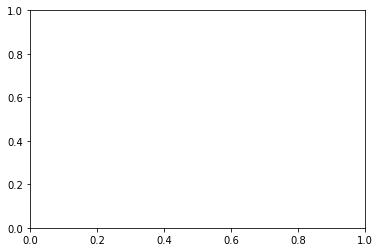

In [49]:
TSNE_plot(train_df_new,y_train)

## Random Forest

In [50]:
########## grid sreach method Random Forest
def HPTing_Model(Train_x, Train_y):
    rf = RandomForestClassifier()
    parameters = {
        'max_features': ['auto', 'sqrt'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap':[True, False],
        'n_estimators':[int(x) for x in np.linspace(start = 5, stop = 500, num = 50)]
    }
    grid = RandomizedSearchCV(rf, parameters, scoring='accuracy', return_train_score=False, cv =5)
    grid_search=grid.fit(Train_x, Train_y)
    return grid_search        

In [51]:
#Hyperparameter Tuning
Parameters = HPTing_Model(train_df_new, y_train)

#build the tuned model
#edit the parameters here according to your defined parameter space and model's grid
model_rf = RandomForestClassifier(max_features=Parameters.best_estimator_.get_params()['max_features'],
                    max_depth=Parameters.best_estimator_.get_params()['max_depth'],
                    min_samples_split=Parameters.best_estimator_.get_params()['min_samples_split'],
                    min_samples_leaf=Parameters.best_estimator_.get_params()['min_samples_leaf'],
                    bootstrap=Parameters.best_estimator_.get_params()['bootstrap'],
                    n_estimators=Parameters.best_estimator_.get_params()['n_estimators'])

#fit the built model
model_rf.fit(train_df_new, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='auto',
                       min_samples_leaf=2, n_estimators=166)

In [52]:
y_pred_train_rf = model_rf.predict(train_df_new)
y_pred_test_rf  = model_rf.predict(valid_df_new)
y_prediction_values_rf=model_rf.predict_proba(valid_df_new)

In [53]:
# Predictions Table
pred_df_rf = pd.DataFrame()
pred_df_rf['Samples'] = test_pids
pred_df_rf['Actual Severity Status'] = y_test
pred_df_rf['Predicted Severity Status'] = y_pred_test_rf
pred_df_rf

,Samples,Actual Severity Status,Predicted Severity Status
10,COVIRL-201-002,moderate,critical_severe
70,AIIDV1439,mild,mild
47,AIIDV0379,mild,mild
54,AIIDV0083,mild,mild
40,COVIRL-202-010,moderate,critical_severe
65,AIIDV1002,mild,mild
59,AIIDV0364,mild,moderate
81,COVIRL-201-035,critical_severe,critical_severe
77,AIIDM0040,moderate,mild
45,AIIDV0485,critical_severe,critical_severe


In [54]:
pred_df_rf.to_csv('Predictions_Table_RF_MultiClass.csv',index=False)

In [55]:
print("Training Accuracy :",metrics.accuracy_score(y_train, y_pred_train_rf))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_rf))

Training Accuracy : 1.0
Testing Accuracy: 0.47619047619047616


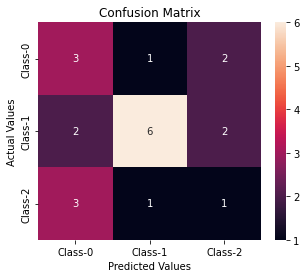

<Figure size 432x288 with 0 Axes>

In [57]:
# Creating  a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_test_rf)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Class-0','Class-1','Class-2'], 
                     columns = ['Class-0','Class-1','Class-2'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
plt.savefig("ConfusionMatrix_RF_multiclass.png", bbox_inches='tight', dpi=600)

### Feature Importance

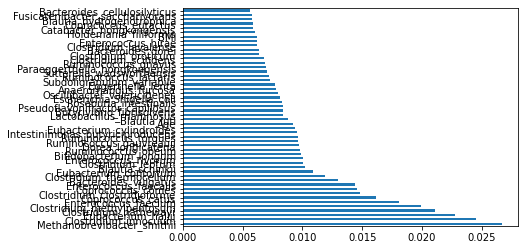

<Figure size 432x288 with 0 Axes>

In [58]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model_rf.feature_importances_, index = train_df_new.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.show()
plt.savefig('FeatureImportance_RF_Multiclass.png',dpi=600);

In [59]:
# Top 50 features
feat_importances.nlargest(50)

Methanobrevibacter_smithii          0.026689
Clostridium_innocuum                0.024544
Eubacterium_hallii                  0.022768
Clostridium_hathewayi               0.021103
Clostridium_methylpentosum          0.019917
Enterococcus_faecium                0.018120
Coprococcus_catus                   0.016130
Clostridium_clostridioforme         0.014829
Coprococcus_comes                   0.014584
Enterococcus_faecalis               0.014416
Bacteroides_vulgatus                0.012937
Clostridium_thermocellum            0.011879
Eubacterium_contortum               0.010913
Blautia_schinkii                    0.010222
Clostridium_leptum                  0.010061
Enterococcus_rivorum                0.010019
Bifidobacterium_longum              0.009871
Ruminococcus_obeum                  0.009819
Dorea_longicatena                   0.009677
Ruminococcus_gauvreauii             0.009641
Ruminococcus_torques                0.009599
Intestinimonas_butyriciproducens    0.009568
Eubacteriu

In [61]:
## Saving the top 50 features
pd.DataFrame(feat_importances.nlargest(50)).to_csv('top50features_RF_multiclass.csv',index=False)

In [63]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 19.4 MB/s eta 0:00:00


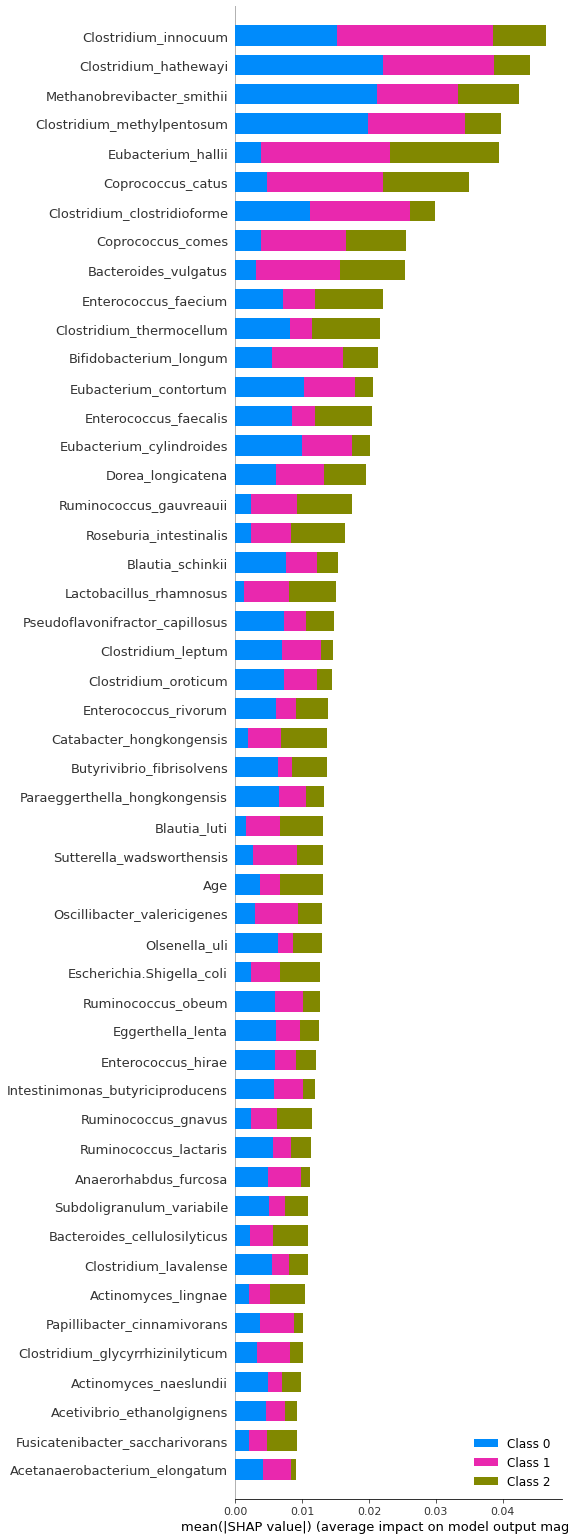

In [65]:
## Tree based learners can be beautifully explored using SHAP, as shown below.
import shap

f_rf = plt.figure()
shap_values_rf = shap.TreeExplainer(model_rf).shap_values(valid_df_new)
shap.summary_plot(shap_values_rf, train_df_new,max_display=50)
f_rf.savefig("SHAP_summary_plot_RF_multi.png", bbox_inches='tight', dpi=600)

# SVM

### Without Grid Search

In [66]:
svm_model_linear = SVC(kernel = 'linear', C = 1, probability=True).fit(train_df_new, y_train)

In [67]:
y_pred_train_svm = svm_model_linear.predict(train_df_new)
y_pred_test_svm  = svm_model_linear.predict(valid_df_new)
y_prediction_values_svm = svm_model_linear.predict_proba(valid_df_new) ####### Prediction Probabilites

In [68]:
print("Training Accuracy :",metrics.accuracy_score(y_train, y_pred_train_svm))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_svm))

Training Accuracy : 1.0
Testing Accuracy: 0.3333333333333333


In [69]:
# Predictions Table
pred_df_svm = pd.DataFrame()
pred_df_svm['Samples'] = test_pids
pred_df_svm['Actual Severity Status'] = y_test
pred_df_svm['Predicted Severity Status'] = y_pred_test_svm
pred_df_svm

,Samples,Actual Severity Status,Predicted Severity Status
10,COVIRL-201-002,moderate,critical_severe
70,AIIDV1439,mild,mild
47,AIIDV0379,mild,moderate
54,AIIDV0083,mild,critical_severe
40,COVIRL-202-010,moderate,mild
65,AIIDV1002,mild,critical_severe
59,AIIDV0364,mild,moderate
81,COVIRL-201-035,critical_severe,mild
77,AIIDM0040,moderate,mild
45,AIIDV0485,critical_severe,critical_severe


In [71]:
pred_df_svm.to_csv('Predictions_Table_SVM_MultiClass.csv',index=False)

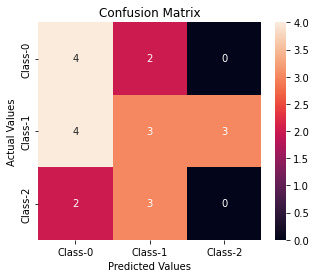

<Figure size 432x288 with 0 Axes>

In [72]:
# Creating  a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_test_svm)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Class-0','Class-1','Class-2'], 
                     columns = ['Class-0','Class-1','Class-2'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
plt.savefig("ConfusionMatrix_SVM_multiclass.png", bbox_inches='tight', dpi=600)

### With Grid Search CV

In [73]:
##### Grid Search #####
def HPTing_Model(Train_x, Train_y):
    svc_rand = SVC(probability=True)
    parameters = {
        'kernel':('linear', 'rbf'),
        'C': [0.01, 0.1, 0.2, 0.5, 0.6, 0.8, 1.0], 
        'gamma': [0.01, 0.02, 0.05, 0.1, 1.0, 1.2],
    }
    grid = RandomizedSearchCV(svc_rand, parameters, cv = 5)
    grid_search=grid.fit(Train_x, Train_y)
    return grid_search

In [74]:
#Hyperparameter Tuning
Parameters = HPTing_Model(train_df_new, y_train)

#build the tuned model
#edit the parameters here according to your defined parameter space and model's grid
model_svmg = SVC(kernel=Parameters.best_estimator_.get_params()['kernel'],
                    C=Parameters.best_estimator_.get_params()['C'],
                    gamma=Parameters.best_estimator_.get_params()['gamma'],probability=True)

#fit the built model
model_svmg.fit(train_df_new, y_train)

SVC(C=0.1, gamma=1.2, probability=True)

In [75]:
y_pred_train_svmg = model_svmg.predict(train_df_new)
y_pred_test_svmg  = model_svmg.predict(valid_df_new)
y_prediction_values_svmg = model_svmg.predict_proba(valid_df_new) ####### Prediction Probabilites

In [76]:
print("Training Accuracy :",metrics.accuracy_score(y_train, y_pred_train_svmg))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_svmg))

Training Accuracy : 0.4262295081967213
Testing Accuracy: 0.2857142857142857


In [77]:
# Predictions Table
pred_df_svmg = pd.DataFrame()
pred_df_svmg['Samples'] = test_pids
pred_df_svmg['Actual Severity Status'] = y_test
pred_df_svmg['Predicted Severity Status'] = y_pred_test_svmg
pred_df_svmg

,Samples,Actual Severity Status,Predicted Severity Status
10,COVIRL-201-002,moderate,critical_severe
70,AIIDV1439,mild,critical_severe
47,AIIDV0379,mild,critical_severe
54,AIIDV0083,mild,critical_severe
40,COVIRL-202-010,moderate,critical_severe
65,AIIDV1002,mild,critical_severe
59,AIIDV0364,mild,critical_severe
81,COVIRL-201-035,critical_severe,critical_severe
77,AIIDM0040,moderate,critical_severe
45,AIIDV0485,critical_severe,critical_severe


In [79]:
pred_df_svmg.to_csv('Predictions_Table_SVMGrid_MultiClass.csv',index=False)

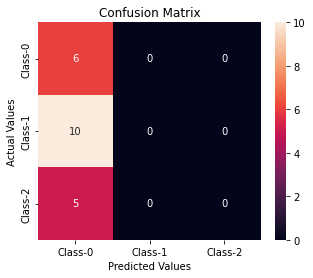

<Figure size 432x288 with 0 Axes>

In [81]:
# Creating  a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_test_svmg)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Class-0','Class-1','Class-2'], 
                     columns = ['Class-0','Class-1','Class-2'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
plt.savefig("ConfusionMatrix_SVMGrid_multi.png", bbox_inches='tight', dpi=600)

### Feature Importance

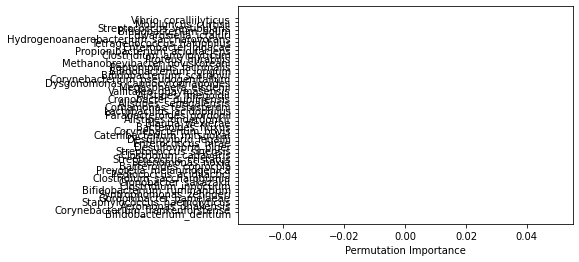

In [83]:
perm_importance = permutation_importance(model_svmg, valid_df_new, y_test)

features = np.array(features)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx][:50], perm_importance.importances_mean[sorted_idx][:50])
plt.xlabel("Permutation Importance")
plt.savefig('FeatureImportance_SVMGrid_Multi.png',dpi=300);

In [84]:
# Top 50 Features
features[sorted_idx][:50]

array(['Bifidobacterium_dentium', 'Corynebacterium_frankenforstense',
       'Aeromonas_dhakensis', 'Staphylococcus_haemolyticus',
       'Gordonibacter_pamelaeae', 'Syntrophomonas_zehnderi',
       'Bifidobacterium_ruminantium', 'Clostridium_innocuum',
       'Cronobacter_sakazakii', 'Clostridium_saccharogumia',
       'Pediococcus_acidilactici', 'Prevotella_melaninogenica',
       'Bacteroides_coprocola', 'Selenomonas_noxia',
       'Streptococcus_cristatus', 'Clostridium_cadaveris',
       'Streptococcus_sinensis', 'Desulfovibrio_piger',
       'Enterococcus_hirae', 'Desulfovibrio_legallii',
       'Catenibacterium_mitsuokai', 'Corynebacterium_bovis',
       'Bacteroides_fluxus', 'Blautia_wexlerae', 'Alistipes_onderdonkii',
       'Parabacteroides_gordonii', 'Lactobacillus_acidophilus',
       'Comamonas_testosteroni', 'Alistipes_senegalensis',
       'Cronobacter_dublinensis', 'Alistipes_finegoldii',
       'Vallitalea_guaymasensis', 'Megasphaera_elsdenii',
       'Dysgonomonas_cap

In [85]:
# Saving top 50 features
pd.DataFrame(list(features[sorted_idx][:50])).to_csv('top50features_SVMGrid_multiclass.csv',index=False)

### Saving the models

In [86]:
#Saving the final models
joblib.dump(model_rf, 'RF_MultiClassModel.pkl')
joblib.dump(svm_model_linear, 'SVM_Linear_MultiClassModel.pkl')
joblib.dump(model_svmg, 'SVMGrid_MultiClassModel.pkl')

['SVMGrid_MultiClassModel.pkl']

# Binary Classification

In [117]:
dataf['WHO_severity'].value_counts()

critical_severe    32
mild               31
moderate           19
Name: WHO_severity, dtype: int64

In [127]:
## Selecting the two extreme groups for binary classification
data_ff = dataf[dataf['WHO_severity']=='mild'].append(dataf[dataf['WHO_severity']=='critical_severe'])


data_ff.reset_index(drop=True,inplace=True)
data_ff

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,PID,Bifidobacterium_dentium,Actinobacillus_capsulatus,Clostridium_tepidiprofundi,Butyricimonas_synergistica,Erwinia_mallotivora,Slackia_heliotrinireducens,Parvibacter_caecicola,Pantoea_rwandensis,Brenneria_alni,...,Desulfovibrio_desulfuricans,Streptococcus_danieliae,Bacteroides_barnesiae,Catonella_morbi,Listeria_fleischmannii,Sex,Age,BMI,comorbidities_total,WHO_severity
0,AIIDV1015,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,42,57.795561,2,mild
1,AIIDV1406,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,2,85,23.728191,8,mild
2,AIIDM0021,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,68,30.322325,0,mild
3,AIIDV0361,0,0,0,0,0,0,0,0,0,...,0,0,7,0,0,1,82,25.092850,3,mild
4,AIIDV1693,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,2,70,25.641873,1,mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,COVIRL-201-030,34,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,61,26.101204,4,critical_severe
59,COVIRL-201-019,0,0,0,9,0,2,0,1,0,...,24,0,0,0,0,1,77,20.752984,0,critical_severe
60,COVIRL-201-015,2379,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,87,25.562130,3,critical_severe
61,AIIDV1085,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,1,78,26.543210,5,critical_severe


In [128]:
#check for duplicates
duplicate = data_ff.duplicated()
print(duplicate.sum())

0


In [129]:
### splitting of data in 75-25
X_train, X_test,y_train,y_test = train_test_split(data_ff,data_ff["WHO_severity"] ,test_size=0.25, random_state=1)

In [130]:
test_pids = X_test['PID']

In [131]:
train_df_new = X_train.drop(['PID','WHO_severity'], axis=1)
valid_df_new = X_test.drop(['PID','WHO_severity'], axis=1)

In [132]:
features = list(train_df_new.columns)

## Visualization of Class Representations

In [178]:
def TSNE_plot(data,data_labels):
        tsne = TSNE(n_components=2, random_state=50)
        transformed_data = tsne.fit_transform(data)
        k = np.array(transformed_data)
        Group=["Class 0", "Class 1"]
        plt.scatter(k[:, 0],k[:, 1], c=data_labels)
        plt.legend(loc="lower right")
        plt.show()

ValueError: ignored

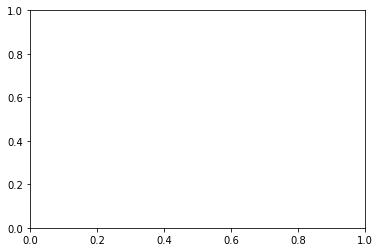

In [179]:
TSNE_plot(train_df_new,y_train)

## Random Forest

In [135]:
########## grid sreach method Random Forest
def HPTing_Model(Train_x, Train_y):
    rf = RandomForestClassifier()
    parameters = {
        'max_features': ['auto', 'sqrt'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap':[True, False],
        'n_estimators':[int(x) for x in np.linspace(start = 5, stop = 500, num = 50)]
    }
    grid = RandomizedSearchCV(rf, parameters, scoring='accuracy', return_train_score=False, cv =5)
    grid_search=grid.fit(Train_x, Train_y)
    return grid_search        

In [136]:
#Hyperparameter Tuning
Parameters = HPTing_Model(train_df_new, y_train)

#build the tuned model
#edit the parameters here according to your defined parameter space and model's grid
model_rf = RandomForestClassifier(max_features=Parameters.best_estimator_.get_params()['max_features'],
                    max_depth=Parameters.best_estimator_.get_params()['max_depth'],
                    min_samples_split=Parameters.best_estimator_.get_params()['min_samples_split'],
                    min_samples_leaf=Parameters.best_estimator_.get_params()['min_samples_leaf'],
                    bootstrap=Parameters.best_estimator_.get_params()['bootstrap'],
                    n_estimators=Parameters.best_estimator_.get_params()['n_estimators'])

#fit the built model
model_rf.fit(train_df_new, y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

RandomForestClassifier(max_depth=90, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=106)

In [137]:
y_pred_train_rf = model_rf.predict(train_df_new)
y_pred_test_rf  = model_rf.predict(valid_df_new)
y_prediction_values_rf=model_rf.predict_proba(valid_df_new)

In [138]:
print("Training Accuracy :",metrics.accuracy_score(y_train, y_pred_train_rf))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_rf))

Training Accuracy : 0.9787234042553191
Testing Accuracy: 0.5625


In [139]:
# Predictions Table
pred_df_rf = pd.DataFrame()
pred_df_rf['Samples'] = test_pids
pred_df_rf['Actual Severity Status'] = y_test
pred_df_rf['Predicted Severity Status'] = y_pred_test_rf
pred_df_rf

,Samples,Actual Severity Status,Predicted Severity Status
24,AIIDV1457,mild,mild
39,COVIRL-201-013,critical_severe,critical_severe
51,COVIRL-201-008,critical_severe,critical_severe
27,AIIDV1439,mild,mild
61,AIIDV1085,critical_severe,mild
2,AIIDM0021,mild,mild
21,AIIDV0364,mild,mild
42,AIIDW001,critical_severe,mild
41,AIIDV0091,critical_severe,mild
44,AIIDV0277,critical_severe,mild


In [140]:
pred_df_rf.to_csv('Predictions_Table_RF_Binary.csv',index=False)

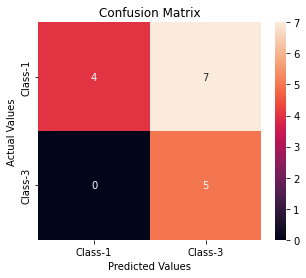

<Figure size 432x288 with 0 Axes>

In [173]:
# Creating  a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_test_rf)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm, index = ['Class-1','Class-3'],columns = ['Class-1','Class-3'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
plt.savefig("ConfusionMatrix_RF_binary.png", bbox_inches='tight', dpi=600)

### Feature Importance

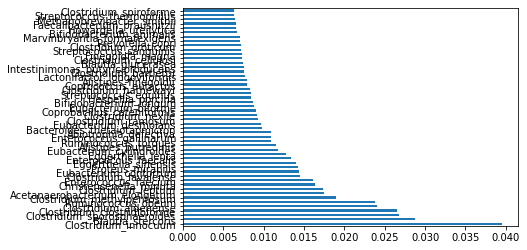

<Figure size 432x288 with 0 Axes>

In [142]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model_rf.feature_importances_, index = train_df_new.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.show()
plt.savefig('FeatureImportance_RF_Binary',dpi=600);

In [143]:
## Saving the top 50 features
pd.DataFrame(feat_importances.nlargest(50)).to_csv('top50features_RF_binary.csv',index=False)

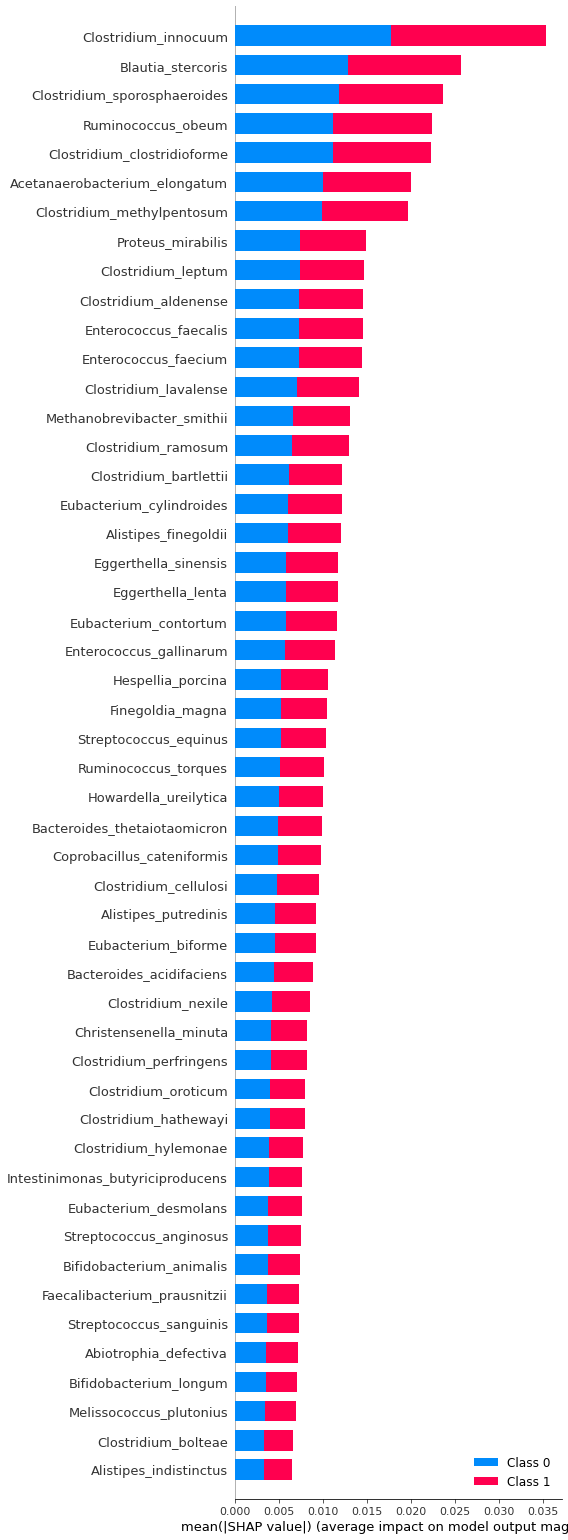

In [144]:
## Tree based learners can be beautifully explored using SHAP, as shown below.
import shap

f_rf = plt.figure()
shap_values_rf = shap.TreeExplainer(model_rf).shap_values(valid_df_new)
shap.summary_plot(shap_values_rf, train_df_new,max_display=50)
f_rf.savefig("SHAP_summary_plot_RF_binary.png", bbox_inches='tight', dpi=600)

# SVM model

### Without Grid Search

In [145]:
svm_model_linear = SVC(kernel = 'linear', C = 1, probability=True).fit(train_df_new, y_train)

In [146]:
y_pred_train_svm = svm_model_linear.predict(train_df_new)
y_pred_test_svm  = svm_model_linear.predict(valid_df_new)
y_prediction_values_svm = svm_model_linear.predict_proba(valid_df_new) ####### Prediction Probabilites

In [147]:
print("Training Accuracy :",metrics.accuracy_score(y_train, y_pred_train_svm))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_svm))

Training Accuracy : 1.0
Testing Accuracy: 0.8125


In [148]:
# Predictions Table
pred_df_svm = pd.DataFrame()
pred_df_svm['Samples'] = test_pids
pred_df_svm['Actual Severity Status'] = y_test
pred_df_svm['Predicted Severity Status'] = y_pred_test_svm
pred_df_svm

,Samples,Actual Severity Status,Predicted Severity Status
24,AIIDV1457,mild,mild
39,COVIRL-201-013,critical_severe,critical_severe
51,COVIRL-201-008,critical_severe,critical_severe
27,AIIDV1439,mild,critical_severe
61,AIIDV1085,critical_severe,mild
2,AIIDM0021,mild,mild
21,AIIDV0364,mild,mild
42,AIIDW001,critical_severe,critical_severe
41,AIIDV0091,critical_severe,critical_severe
44,AIIDV0277,critical_severe,critical_severe


In [149]:
pred_df_svm.to_csv('Predictions_Table_SVM_Binary.csv',index=False)

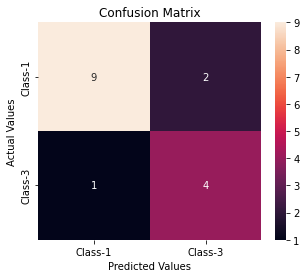

<Figure size 432x288 with 0 Axes>

In [150]:
# Creating  a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_test_svm)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Class-1','Class-3'],
                     columns = ['Class-1','Class-3'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
plt.savefig("Confusion_Matrix_SVM_binary.png", bbox_inches='tight', dpi=600)

### Feature Importance

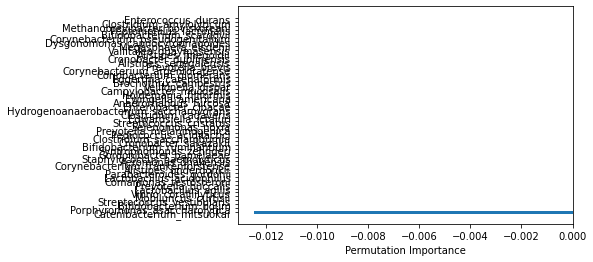

In [151]:
perm_importance = permutation_importance(svm_model_linear, valid_df_new, y_test)

featuress = np.array(features)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(featuress[sorted_idx][:50], perm_importance.importances_mean[sorted_idx][:50])
plt.xlabel("Permutation Importance")
plt.savefig('Feature_Importance_SVM_Binary.png',dpi=600);

In [152]:
# Saving top 50 features
pd.DataFrame(list(featuress[sorted_idx][:50])).to_csv('top50feat_SVM_binary.csv',index=False)

### With Grid Search CV

In [153]:
##### Grid Search #####
def HPTing_Model(Train_x, Train_y):
    svc_rand = SVC(probability=True)
    parameters = {
        'kernel':('linear', 'rbf'),
        'C': [0.01, 0.1, 0.2, 0.5, 0.6, 0.8, 1.0], 
        'gamma': [0.01, 0.02, 0.05, 0.1, 1.0, 1.2],
    }
    grid = RandomizedSearchCV(svc_rand, parameters, cv = 5)
    grid_search=grid.fit(Train_x, Train_y)
    return grid_search

In [154]:
#Hyperparameter Tuning
Parameters = HPTing_Model(train_df_new, y_train)

#build the tuned model
#edit the parameters here according to your defined parameter space and model's grid
model_svmg = SVC(kernel=Parameters.best_estimator_.get_params()['kernel'],
                    C=Parameters.best_estimator_.get_params()['C'],
                    gamma=Parameters.best_estimator_.get_params()['gamma'],probability=True)

#fit the built model
model_svmg.fit(train_df_new, y_train)

SVC(C=0.01, gamma=1.2, kernel='linear', probability=True)

In [155]:
y_pred_train_svmg = model_svmg.predict(train_df_new)
y_pred_test_svmg  = model_svmg.predict(valid_df_new)
y_prediction_values_svmg = model_svmg.predict_proba(valid_df_new) ####### Prediction Probabilites

In [156]:
print("Training Accuracy :",metrics.accuracy_score(y_train, y_pred_train_svmg))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_svmg))

Training Accuracy : 1.0
Testing Accuracy: 0.8125


In [157]:
# Predictions Table
pred_df_svmg = pd.DataFrame()
pred_df_svmg['Samples'] = test_pids
pred_df_svmg['Actual Severity Status'] = y_test
pred_df_svmg['Predicted Severity Status'] = y_pred_test_svmg
pred_df_svmg

,Samples,Actual Severity Status,Predicted Severity Status
24,AIIDV1457,mild,mild
39,COVIRL-201-013,critical_severe,critical_severe
51,COVIRL-201-008,critical_severe,critical_severe
27,AIIDV1439,mild,critical_severe
61,AIIDV1085,critical_severe,mild
2,AIIDM0021,mild,mild
21,AIIDV0364,mild,mild
42,AIIDW001,critical_severe,critical_severe
41,AIIDV0091,critical_severe,critical_severe
44,AIIDV0277,critical_severe,critical_severe


In [158]:
pred_df_svmg.to_csv('Predictions_Table_SVMGrid_Binary.csv',index=False)

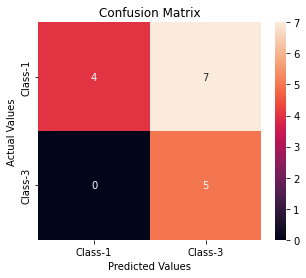

<Figure size 432x288 with 0 Axes>

In [159]:
# Creating  a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_test_rf)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Class-1','Class-3'], 
                     columns = ['Class-1','Class-3'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
plt.savefig("ConfusionMatrix_SVMGrid_binary.png", bbox_inches='tight', dpi=600)

### Feature Importance

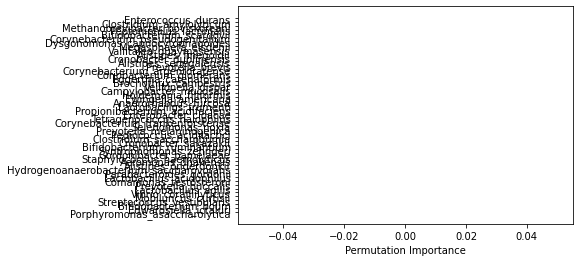

In [160]:
perm_importance = permutation_importance(model_svmg, valid_df_new, y_test)

featuress = np.array(features)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(featuress[sorted_idx][:50], perm_importance.importances_mean[sorted_idx][:50])
plt.xlabel("Permutation Importance")
plt.savefig('Feature_Importance_SVMGrid_Binary.png',dpi=600);

In [162]:
# Saving top 50 features
pd.DataFrame(list(featuress[sorted_idx][:50])).to_csv('top50features_SVMGrid_Binary.csv',index=False)

## K-Nearest Neighbours model

In [163]:
def HPTing_Model(Train_x, Train_y):
    leaf_size = list(range(1,50))
    n_neighbors = list(range(1,40))
    p=list(range(1,20))
    #Convert to dictionary
    hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, weights=['uniform','distance'], metric= ['minkowski','euclidean','manhattan'])
    #Create new KNN object
    knn = KNeighborsClassifier()
    #Use GridSearch
    knn_Grid = RandomizedSearchCV(knn, hyperparameters, cv=5, verbose=2, n_jobs = -1)
    best_model = knn_Grid.fit(Train_x, Train_y)
    return best_model

In [164]:
#Hyperparameter Tuning
Parameters = HPTing_Model(train_df_new, y_train)

#build the tuned model
#edit the parameters here according to your defined parameter space and model's grid
model_knn = KNeighborsClassifier(leaf_size=Parameters.best_estimator_.get_params()['leaf_size'],
                    n_neighbors=Parameters.best_estimator_.get_params()['n_neighbors'],
                    p=Parameters.best_estimator_.get_params()['p'])

#fit the built model
model_knn.fit(train_df_new, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KNeighborsClassifier(leaf_size=26, n_neighbors=20, p=4)

In [165]:
y_pred_train_knn = model_knn.predict(train_df_new)
y_pred_test_knn  = model_knn.predict(valid_df_new)
y_prediction_values_knn = model_knn.predict_proba(valid_df_new) ####### Prediction Probabilites

In [166]:
print("Training Accuracy :",metrics.accuracy_score(y_train, y_pred_train_knn))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_knn))

Training Accuracy : 0.6808510638297872
Testing Accuracy: 0.4375


In [167]:
# Predictions Table
pred_df_knn = pd.DataFrame()
pred_df_knn['Samples'] = test_pids
pred_df_knn['Actual Severity Status'] = y_test
pred_df_knn['Predicted Severity Status'] = y_pred_test_knn
pred_df_knn

,Samples,Actual Severity Status,Predicted Severity Status
24,AIIDV1457,mild,mild
39,COVIRL-201-013,critical_severe,critical_severe
51,COVIRL-201-008,critical_severe,mild
27,AIIDV1439,mild,mild
61,AIIDV1085,critical_severe,mild
2,AIIDM0021,mild,mild
21,AIIDV0364,mild,mild
42,AIIDW001,critical_severe,mild
41,AIIDV0091,critical_severe,mild
44,AIIDV0277,critical_severe,mild


In [168]:
pred_df_knn.to_csv('Predictions_Table_KNN_Binary.csv',index=False)

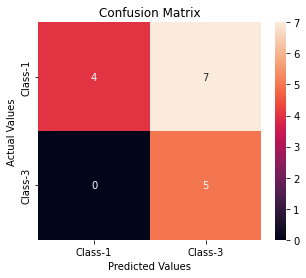

<Figure size 432x288 with 0 Axes>

In [170]:
# Creating  a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred_test_rf)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Class-1','Class-3'], 
                     columns = ['Class-1','Class-3'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
plt.savefig("ConfusionMatrix_KNN_binary.png", bbox_inches='tight', dpi=600)

In [171]:
#Saving the final models
joblib.dump(model_rf, 'RF_BinaryModel.pkl')
joblib.dump(svm_model_linear, 'SVM_Linear_BinaryModel.pkl')
joblib.dump(model_svmg, 'SVMGrid_BinaryModel.pkl')
joblib.dump(model_knn, 'KNN_Binary_Model.pkl')

['KNN_Binary_Model.pkl']